### Generative Adversarial Imitation Learning (GAIL)

#### Problem Setup
The goal of GAIL is to learn a policy $\pi(a|s)$ that mimics the behavior of an expert policy, given expert demonstrations, by leveraging ideas from Generative Adversarial Networks (GANs).

---

#### Framework

GAIL operates in a Markov Decision Process (MDP) with:
- $S$: set of states,
- $A$: set of actions,
- $P(s'|s,a)$: transition probabilities,
- $\gamma$: discount factor.

The objective is to find a policy $\pi(a|s)$ that minimizes the divergence between the occupancy measure of the expert policy and the learned policy.

---

#### Discriminator Loss
The discriminator $D(s, a)$ aims to distinguish between state-action pairs from the expert policy and the learned policy. The loss function for $D$ is:
$$
\mathcal{L}_D = \mathbb{E}_{(s,a) \sim \pi} [\log D(s, a)] + \mathbb{E}_{(s,a) \sim \pi_E} [\log(1 - D(s, a))],
$$
where:
- $\pi_E$: expert policy,
- $\pi$: learned policy.

---

#### Policy Loss
The policy $\pi(a|s)$ is updated using reinforcement learning, guided by the discriminator. The policy optimization maximizes:
$$
\mathcal{L}_\pi = \mathbb{E}_{(s,a) \sim \pi} [\log D(s, a)] - \lambda \mathbb{H}(\pi),
$$
where $\mathbb{H}(\pi)$ is the entropy of the policy, added to encourage exploration.

---

#### Training Procedure

1. **Initialization**:
   - Initialize policy $\pi_\theta$ and discriminator $D_\phi$.

2. **Discriminator Update**:
   - Sample state-action pairs from the expert policy $\pi_E$.
   - Sample state-action pairs from the learned policy $\pi$.
   - Update $D_\phi$ to minimize $\mathcal{L}_D$.

3. **Policy Update**:
   - Update $\pi_\theta$ to maximize $\mathcal{L}_\pi$ using a reinforcement learning algorithm (e.g., TRPO, PPO).

4. **Repeat**:
   - Alternate between updating $D_\phi$ and $\pi_\theta$ until convergence.

---

#### Optimization Objective
GAIL seeks to match the occupancy measure of the learned policy $\pi$ with that of the expert policy $\pi_E$ by solving:
$$
\min_\pi \max_D \mathbb{E}_{(s,a) \sim \pi} [\log D(s, a)] + \mathbb{E}_{(s,a) \sim \pi_E} [\log(1 - D(s, a))].
$$

---

#### Experimental Setup
- **GridWorld Environment**:
  - $S = 25$: grid size $5 \times 5$.
  - $A = 4$: actions (up, down, left, right).
  - Obstacles and goal states are predefined.

- **Expert Demonstrations**:
  - Collected using a predefined optimal policy.
  - Used to train the discriminator.

- **Policy Training**:
  - Policy network and value network are updated using Proximal Policy Optimization (PPO).
  - Discriminator is updated using binary cross-entropy loss.

---

#### Results Visualization
1. **Discriminator Loss**:
   - Plot of discriminator loss over iterations to monitor training stability.

2. **Policy Performance**:
   - Evaluate the learned policy by comparing its behavior with the expert policy.
   - Plot cumulative rewards over episodes to verify convergence.

Iter 0, D Loss: 1.3877
Iter 100, D Loss: 1.2171
Iter 200, D Loss: 1.1959
Iter 300, D Loss: 1.1907
Iter 400, D Loss: 1.1813
Iter 500, D Loss: 1.1940
Iter 600, D Loss: 1.1928
Iter 700, D Loss: 1.1848
Iter 800, D Loss: 1.1868
Iter 900, D Loss: 1.1775


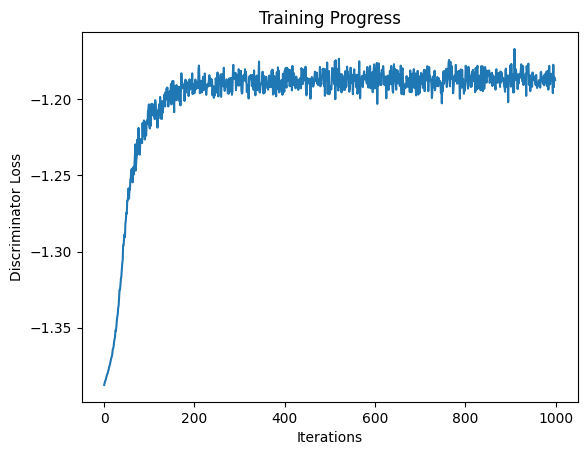

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import itertools

# Simple GridWorld Environment
class SimpleGridWorld:
    def __init__(self, grid_size=5, goal_state=(4, 4), start_state=(0, 0), obstacles=None, max_steps=50):
        self.grid_size = grid_size
        self.goal_state = goal_state
        self.start_state = start_state
        self.obstacles = obstacles if obstacles else []
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.agent_position = self.start_state
        self.steps_taken = 0
        return self.agent_position

    def step(self, action):
        moves = {
            0: (-1, 0),  # Up
            1: (0, 1),   # Right
            2: (1, 0),   # Down
            3: (0, -1),  # Left
        }
        self.steps_taken += 1
        move = moves[action]
        new_position = (
            self.agent_position[0] + move[0],
            self.agent_position[1] + move[1],
        )
        if (0 <= new_position[0] < self.grid_size) and (0 <= new_position[1] < self.grid_size):
            self.agent_position = new_position
        if self.agent_position in self.obstacles:
            return self.agent_position, -1, False
        elif self.agent_position == self.goal_state:
            return self.agent_position, 10, True
        else:
            return self.agent_position, -0.1, self.steps_taken >= self.max_steps

    def render(self):
        grid = np.full((self.grid_size, self.grid_size), '.')
        for obs in self.obstacles:
            grid[obs] = 'X'
        grid[self.goal_state] = 'G'
        grid[self.agent_position] = 'A'
        print("\n".join([" ".join(row) for row in grid]))
        print()

# Create Environment
obstacles = [(1, 1), (2, 2), (3, 1)]
env = SimpleGridWorld(grid_size=5, goal_state=(4, 4), start_state=(0, 0), obstacles=obstacles)

# Neural Network Definitions
STATE_SIZE = env.grid_size * env.grid_size
ACTION_SIZE = 4  # Up, Right, Down, Left

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolicyNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.hidden = nn.Linear(STATE_SIZE, hidden_dim)
        self.output = nn.Linear(hidden_dim, ACTION_SIZE)

    def forward(self, s):
        outs = F.relu(self.hidden(s))
        return self.output(outs)

class ValueNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.hidden = nn.Linear(STATE_SIZE, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = F.relu(self.hidden(s))
        return self.output(outs)

class DiscriminatorNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.hidden1 = nn.Linear(STATE_SIZE + ACTION_SIZE, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = F.relu(self.hidden1(s))
        outs = F.relu(self.hidden2(outs))
        return torch.sigmoid(self.output(outs))

policy_func = PolicyNet().to(device)
value_func = ValueNet().to(device)
discriminator = DiscriminatorNet().to(device)

# Get Expert Data (Mocked for Simplicity)
def generate_expert_data(env, num_episodes=10):
    expert_states = []
    expert_actions = []
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.random.choice(4)  # Random action
            next_state, reward, done = env.step(action)
            expert_states.append(state[0] * env.grid_size + state[1])
            expert_actions.append(action)
            state = next_state
    return torch.tensor(expert_states), torch.tensor(expert_actions)

exp_states, exp_actions = generate_expert_data(env)

# Loss Functions
def get_discriminator_loss(discriminator_net, exp_states, exp_actions, pi_states, pi_actions):
    states_onehot_pi = F.one_hot(pi_states, num_classes=STATE_SIZE).float()
    actions_onehot_pi = F.one_hot(pi_actions, num_classes=ACTION_SIZE).float()
    state_action_pi = torch.cat((states_onehot_pi, actions_onehot_pi), dim=-1)
    d_pi = discriminator_net(state_action_pi).squeeze(dim=-1)

    states_onehot_exp = F.one_hot(exp_states, num_classes=STATE_SIZE).float()
    actions_onehot_exp = F.one_hot(exp_actions, num_classes=ACTION_SIZE).float()
    state_action_exp = torch.cat((states_onehot_exp, actions_onehot_exp), dim=-1)
    d_exp = discriminator_net(state_action_exp).squeeze(dim=-1)

    mean_loss_pi = F.binary_cross_entropy(d_pi, torch.ones_like(d_pi).to(device))
    mean_loss_exp = F.binary_cross_entropy(d_exp, torch.zeros_like(d_exp).to(device))

    return mean_loss_pi + mean_loss_exp

def get_policy_loss(policy_net, states, actions, logits, advantages, discount):
    logits_old = logits
    s_onehot = F.one_hot(states, num_classes=STATE_SIZE)
    logits_new = policy_net(s_onehot.float())

    logprb_old = -F.cross_entropy(logits_old, actions, reduction="none")
    logprb_new = -F.cross_entropy(logits_new, actions, reduction="none")
    prb_ratio = torch.exp(logprb_new - logprb_old)
    advantage_loss = prb_ratio * advantages

    value_loss = torch.mean(advantages**2)

    l_old = logits_old - torch.amax(logits_old, dim=1, keepdim=True)
    l_new = logits_new - torch.amax(logits_new, dim=1, keepdim=True)
    e_old = torch.exp(l_old)
    e_new = torch.exp(l_new)
    e_sum_old = torch.sum(e_old, dim=1, keepdim=True)
    e_sum_new = torch.sum(e_new, dim=1, keepdim=True)
    p_old = e_old / e_sum_old
    kl_loss = torch.sum(
        p_old * (l_old - torch.log(e_sum_old) - l_new + torch.log(e_sum_new)),
        dim=1,
        keepdim=True
    )

    entropy_loss = -discount * logprb_new

    return advantage_loss, value_loss, kl_loss, entropy_loss

# Training Loop
reward_records = []
opt_d = torch.optim.AdamW(discriminator.parameters(), lr=0.001)
opt_pi = torch.optim.AdamW(list(policy_func.parameters()) + list(value_func.parameters()), lr=0.001)

for iter_num in range(1000):
    states_ex, actions_ex = exp_states, exp_actions  # Expert data

    # Generate learner data (Mocked for simplicity; replace with policy sampling logic)
    states = torch.randint(0, STATE_SIZE, (6000,)).to(device)
    actions = torch.randint(0, ACTION_SIZE, (6000,)).to(device)
    logits = policy_func(F.one_hot(states, num_classes=STATE_SIZE).float())
    advantages = torch.rand_like(actions.float()).to(device)
    discount = torch.rand_like(actions.float()).to(device)

    # Update Discriminator
    d_loss = get_discriminator_loss(discriminator, states_ex, actions_ex, states, actions)
    opt_d.zero_grad()
    d_loss.backward()
    opt_d.step()

    # Update Policy
    adv_loss, val_loss, kl_loss, ent_loss = get_policy_loss(policy_func, states, actions, logits, advantages, discount)
    pi_loss = adv_loss + val_loss * 0.01 + kl_loss * 1.0 + ent_loss * 0.005
    opt_pi.zero_grad()
    pi_loss.sum().backward()
    opt_pi.step()

    # Log
    reward_records.append(-d_loss.item())  # Log discriminator loss for simplicity
    if iter_num % 100 == 0:
        print(f"Iter {iter_num}, D Loss: {d_loss.item():.4f}")

# Plot Results
plt.plot(reward_records)
plt.xlabel("Iterations")
plt.ylabel("Discriminator Loss")
plt.title("Training Progress")
plt.show()
